## Evaluating the performance of clustering algorithms


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

### Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cluster_eval"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Utility function

In [2]:
def load_data(input_file):
    X = []
    with open(input_file, 'r') as f:
        for line in f.readlines():
            data = [float(x) for x in line.split(',')]
            X.append(data)

    return np.array(X)

### Load and plot the data

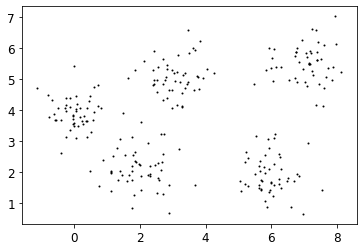

In [3]:
# Load data
X = load_data('./data_perf.txt')

# Plot data
plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

### Silhouette coefficeint score

A good way to measure a clustering algorithm is by seeing how well the clusters are separated. Silhouette Coefficient score is for each data point and the calculation is defined as follows:

score = (a(i) - b(i)) / max(a(i), b(i)) for data point i. 

- a(i) is the average distance between the current data point i and all the other data points in the same cluster.

- b(i) is the average distance between the current data point i and all the data points in the the nearest cluster. 

## 1. K-means clustering algorithm

### k-means clustering evaluation 

In [4]:
from sklearn import metrics
from sklearn.cluster import KMeans

scores = []
score_max = -1
k_best = 0

k_values = np.arange(2, 10)

# k is the number of clusters
# iterate through a range of k values and find the best
for k in k_values:
    # Train the model
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit(X)
    
    # extract performance metrics
    score = metrics.silhouette_score(X, kmeans.labels_, 
                metric='euclidean', sample_size=len(X))

    print('\n k = {:} --> Silhouette score = {:.4f}'.format(k, score))
                    
    scores.append(score)
    if score > score_max:
        score_max = score
        k_best = k
        
        
# Best params
print('\nBest k = {:} --> silhouette score: {:.4f}'.format(k_best, score_max))


 k = 2 --> Silhouette score = 0.5290

 k = 3 --> Silhouette score = 0.5552

 k = 4 --> Silhouette score = 0.5833

 k = 5 --> Silhouette score = 0.6583

 k = 6 --> Silhouette score = 0.5992

 k = 7 --> Silhouette score = 0.5166

 k = 8 --> Silhouette score = 0.4481

 k = 9 --> Silhouette score = 0.3857

Best k = 5 --> silhouette score: 0.6583


### Plot Silhouette scores

Text(0.5, 1.0, 'Silhouette score vs number of clusters')

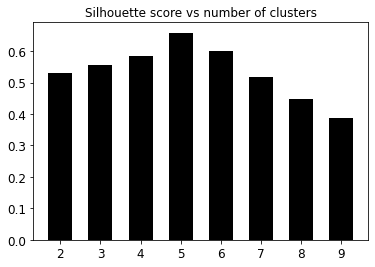

In [5]:
# Plot Silhouette scores
plt.figure()
plt.bar(k_values, scores, width=0.6, color='k', align='center')
plt.title('Silhouette score vs number of clusters')

## 2. Estimating the number of clusters using DBSCAN algorithm

k-means algorithm requires the number of clusters as one of its parameters. In the real world, we wouldn't have this information available. We can definitely sweep the parameter space to find out the optimal number of clusters using the silhouette coefficient score (or the cost function), but thsi might be an expensive process. 

Another way we can find the number of clusters in the data is to apply the Density-Based Spatial Clustering of Applications with Noise (DBSCAN) algorithm. DBSCAN works by treating data points as groups of dense clusters. If a point belongs to a cluster, then there should be a lot of othe points that belong to the same cluster. One of the parameters that we can control is the maximum distance of this point from other points, which is called epsilon. No two points in a given cluster should be further away than epsilon. One of the main advantages of this algorithm is that it can deal with outliers. If there are some points located alone in a low-density area, DBSCAN will detect these points as outliers as opposed to forcing them into a cluster. 

### DBSCAN clustering evaluation

In [6]:
from itertools import cycle
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Find the best epsilon
eps_grid = np.linspace(0.3, 1.2, num=10)

silhouette_scores = []
eps_best = eps_grid[0]

silhouette_score_max = -1
model_best = None
labels_best = None

# finding the best epsilon
for eps in eps_grid:
    # Train DBSCAN clustering model
    model = DBSCAN(eps=eps, min_samples=5).fit(X)

    # extract performance metric 
    silhouette_score = round(metrics.silhouette_score(X, model.labels_), 4)
    silhouette_scores.append(silhouette_score)

    print("Epsilon: {:.4f} --> silhouette score: {:.4f}".format(eps, silhouette_score))

    if silhouette_score > silhouette_score_max:
        silhouette_score_max = silhouette_score
        eps_best = eps
        model_best = model
        labels_best = model.labels_
    
# Best params
print('\nBest epsilon = {:.4f}'.format(eps_best))

# Check for unassigned datapoints in the labels
offset = 0
if -1 in labels_best:
    offset = 1

# Number of clusters in the data 
num_clusters = len(set(labels_best)) - offset 

print("\nEstimated number of clusters =", num_clusters)

Epsilon: 0.3000 --> silhouette score: 0.1287
Epsilon: 0.4000 --> silhouette score: 0.3594
Epsilon: 0.5000 --> silhouette score: 0.5134
Epsilon: 0.6000 --> silhouette score: 0.6165
Epsilon: 0.7000 --> silhouette score: 0.6322
Epsilon: 0.8000 --> silhouette score: 0.6366
Epsilon: 0.9000 --> silhouette score: 0.5142
Epsilon: 1.0000 --> silhouette score: 0.5629
Epsilon: 1.1000 --> silhouette score: 0.5629
Epsilon: 1.2000 --> silhouette score: 0.5629

Best epsilon = 0.8000

Estimated number of clusters = 5


### Plot Silhouette scores

Text(0.5, 1.0, 'Silhouette score vs epsilon')

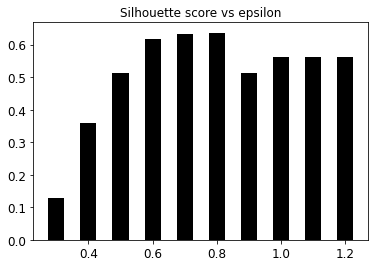

In [7]:
# Plot silhouette scores vs epsilon
plt.figure()
plt.bar(eps_grid, silhouette_scores, width=0.05, color='k', align='center')
plt.title('Silhouette score vs epsilon')

### Plot the clusters

C:\Users\Lucas\AppData\Local\Temp/ipykernel_25756/3087489642.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_core = np.zeros(labels_best.shape, dtype=np.bool)


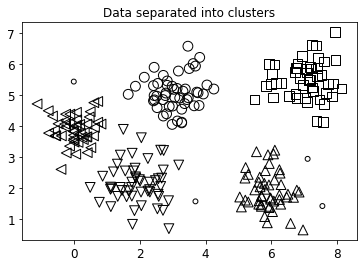

In [8]:
# Extracts the core samples from the trained model
mask_core = np.zeros(labels_best.shape, dtype=np.bool)
mask_core[model.core_sample_indices_] = True

# Plot resultant clusters 
plt.figure()
labels_uniq = set(labels_best)
markers = cycle('vo^s<>')

for cur_label, marker in zip(labels_uniq, markers):
    # Use black dots for unassigned datapoints
    if cur_label == -1:
        marker = '.'

    # Create mask for the current label
    cur_mask = (labels_best == cur_label)

    cur_data = X[cur_mask & mask_core]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker,
             edgecolors='black', s=96, facecolors='none')

    cur_data = X[cur_mask & ~mask_core]
    plt.scatter(cur_data[:, 0], cur_data[:, 1], marker=marker,
             edgecolors='black', s=32)

plt.title('Data separated into clusters')
plt.show()